## Stardog Knowledge Graph Setup and Configuration
1. Configure Stardog connection using environment variables
2. Create a StardogClient class for handling database operations
3. Implement query, get_schema and update methods for SPARQL operations

In [ ]:
import os
from dotenv import load_dotenv
import stardog

load_dotenv()

# Stardog configuration
STARDOG_ENDPOINT = os.getenv("STARDOG_ENDPOINT")
STARDOG_DATABASE = os.getenv("STARDOG_DATABASE")
STARDOG_USERNAME = os.getenv("STARDOG_USERNAME")
STARDOG_PASSWORD = os.getenv("STARDOG_PASSWORD")

print("STARDOG_DATABASE: ", STARDOG_DATABASE)

# StardogClient class for database connection and queries
class StardogClient:
    def __init__(self, endpoint, database, username, password):
        self.endpoint = endpoint
        self.database = database
        self.connection_details = {
            'endpoint': endpoint,
            'username': username,
            'password': password
        }
        self.database = database

    def query(self, sparql_query, use_reasoning=True):
        """Execute a SPARQL query against Stardog"""
        try:
            with stardog.Connection(self.database, **self.connection_details) as conn:
                # Execute the query with reasoning if enabled
                result = conn.select(sparql_query, reasoning=use_reasoning)
                return result
        except Exception as e:
            print(f"Error executing SPARQL query: {e}")
            return None

    def update(self, sparql_update):
        """Execute a SPARQL UPDATE query"""
        try:
            with stardog.Connection(self.database, **self.connection_details) as conn:
                conn.begin()
                conn.update(sparql_update)
                conn.commit()
                return True
        except Exception as e:
            print(f"Error executing SPARQL update: {e}")
            return False

    def get_schema(self):
        """Get the ontology schema from the knowledge graph, including classes, properties, and their domains and ranges."""
        schema_details_query = """
        SELECT ?s ?p ?o
        FROM <https://a.in/sales/ontology>
        WHERE {
            ?s ?p ?o
        }
        """
        schema_result = self.query(schema_details_query, use_reasoning=False)
        if schema_result and schema_result.get('results', {}).get('bindings'):
            triples = schema_result['results']['bindings']

            classes = set()
            object_properties = {}
            datatype_properties = {}

            ontology_base = 'https://a.in/sales/ontology#'
            def short_name(uri):
                return uri[len(ontology_base):] if uri.startswith(ontology_base) else uri

            for triple in triples:
                subject = triple['s']['value']
                predicate = triple['p']['value']
                obj = triple['o']['value']

                # Identify classes
                if predicate == 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type':
                    if obj == 'http://www.w3.org/2002/07/owl#Class':
                        cls = short_name(subject)
                        if cls != 'https://a.in/sales/ontology':
                            classes.add(cls)
                    elif obj == 'http://www.w3.org/2002/07/owl#ObjectProperty':
                        op = short_name(subject)
                        if op not in object_properties:
                            object_properties[op] = {'domain': None, 'range': None}
                    elif obj == 'http://www.w3.org/2002/07/owl#DatatypeProperty':
                        dp = short_name(subject)
                        if dp not in datatype_properties:
                            datatype_properties[dp] = {'domain': None, 'range': None}

                # Identify domain/range
                if predicate == 'http://www.w3.org/2000/01/rdf-schema#domain':
                    prop = short_name(subject)
                    val = short_name(obj)
                    if prop in object_properties:
                        object_properties[prop]['domain'] = val
                    elif prop in datatype_properties:
                        datatype_properties[prop]['domain'] = val
                if predicate == 'http://www.w3.org/2000/01/rdf-schema#range':
                    prop = short_name(subject)
                    val = short_name(obj)
                    if prop in object_properties:
                        object_properties[prop]['range'] = val
                    elif prop in datatype_properties:
                        datatype_properties[prop]['range'] = val

            return {
                'classes': sorted(classes),
                'object_properties': object_properties,
                'datatype_properties': datatype_properties,
                'raw_result': schema_result
            }
        return None

# Initialize Stardog client
stardog_client = StardogClient(STARDOG_ENDPOINT, STARDOG_DATABASE, STARDOG_USERNAME, STARDOG_PASSWORD)
print("Stardog KG client initialized successfully!")

Stardog endpoint: https://sd-682b640b.stardog.cloud:5820
Stardog database: Sales_360
Stardog username: testing
Stardog password: KnowledgeGraph
Stardog KG client initialized successfully!


## SPARQL Agent Implementation
- Environment setup (OpenAI configuration)
- Required imports for the agent
- Type definitions and state management
- Prefix definitions for the e-commerce ontology

In [ ]:
# sparql_agent.py

import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from tabulate import tabulate

# Open AI configuration
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_MODEL = os.getenv("OPENAI_MODEL")  # Default model

# Ontology prefixes for e-commerce domain
PREFIXES = """
PREFIX ex: <https://a.in/sales/ontology#>
PREFIX data: <https://a.in/sales/data#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
"""

# Initialize LLM with OpenAI configuration
# Returns a ChatOpenAI instance configured with temperature=1 and model/API settings from environment
def llm_from_api():
    return ChatOpenAI(
        temperature=1,
        base_url=OPENAI_BASE_URL,
        api_key=OPENAI_API_KEY,
        model=OPENAI_MODEL
    )

# Define the state for the agent
class AgentState(TypedDict):
    question: str
    sparql_query: str
    query_result: str
    query_results: list
    attempts: int
    relevance: str
    sparql_error: bool

# Get the schema from the knowledge graph and format it for the LLM
def get_kg_schema():
    """Get a formatted schema summary with classes and relationships in the requested format."""
    schema = stardog_client.get_schema()
    
    if schema:
        # Format the output as requested
        classes_with_properties = {}
        relationships = {}
        
        # Initialize classes dictionary
        for cls in schema['classes']:
            classes_with_properties[cls] = {}
        
        # Group datatype properties by their domain class
        for prop_name, prop_info in schema['datatype_properties'].items():
            domain = prop_info.get('domain')
            range_type = prop_info.get('range', 'string')  # default to string if no range specified
            
            # Extract just the data type from the range URI if it's an XSD type
            if range_type and 'XMLSchema#' in range_type:
                range_type = range_type.split('#')[-1]
            elif range_type and range_type.startswith('http://'):
                range_type = range_type.split('/')[-1].split('#')[-1]
            
            if domain and domain in classes_with_properties:
                classes_with_properties[domain][prop_name] = range_type
        
        # Format object properties as relationships
        for relationship, rel_info in schema['object_properties'].items():
            domain = rel_info.get('domain')
            range_obj = rel_info.get('range')
            relationships[relationship] = {
                'domain': domain,
                'range': range_obj
            }

        # Create the schema dictionary
        schema_dict = {
            'classes': classes_with_properties,
            'relation': relationships
        }
        
        # Convert to string and escape curly braces for LangChain compatibility
        schema_str = str(schema_dict).replace("{", "{{").replace("}", "}}")
        
        print(f"Formatted schema: {schema_str}")
        
        return schema_str
    else:
        return None

## Check Question Relevance

- CheckRelevance model: Defines the structure for relevance responses
- check_relevance function: Evaluates if a question relates to the KG schema using LLM
- Returns "relevant" or "not_relevant" to filter out unrelated questions

In [ ]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the knowledge graph schema. 'relevant' or 'not_relevant'."
    )

# Check if the question is relevant to the knowledge graph schema
def check_relevance(state: AgentState):
    question = state["question"]
    schema = get_kg_schema()
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following knowledge graph schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = llm_from_api()
    
    relevance_checker = check_prompt | llm | StrOutputParser()
    try:
        relevance_response = relevance_checker.invoke({})
        relevance_response = relevance_response.strip().lower()
        
        if "not_relevant" in relevance_response or "not relevant" in relevance_response:
            state["relevance"] = "not_relevant"
        else:
            state["relevance"] = "relevant"
            
        print(f"Relevance determined: {state['relevance']}")
    except Exception as e:
        print(f"Error checking relevance: {str(e)}")
        state["relevance"] = "relevant"  # Default to relevant on error
    
    return state


## SPARQL Query Generation
- Defines ConvertToSPARQL model class with sparql_query field
- Implements convert_nl_to_sparql function to transform natural language questions to SPARQL
- Uses LLM to generate appropriate SPARQL based on knowledge graph schema
- Handles query formatting and prefix inclusion
- Updates agent state with generated SPARQL query

In [ ]:
class ConvertToSPARQL(BaseModel):
    sparql_query: str = Field(
        description="The SPARQL query corresponding to the user's natural language question."
    )

# Convert natural language question to SPARQL query
def convert_nl_to_sparql(state: AgentState):
    question = state["question"]
    schema = get_kg_schema()
    print(f"Converting question to SPARQL: {question}")
    system = """You are an assistant that converts natural language questions into SPARQL queries based on the following knowledge graph schema:

{schema}

Undestand the relationships between the classes and properties.
Also include FROM <https://a.in/sales/data> in the SPARQL query before where clause or after selecting the variables as per the syntax.

Use these common prefixes:
{prefixes}

Provide only the SPARQL query without any explanations. Use appropriate variable names and include necessary JOINs via triple patterns.

Return ONLY the SPARQL query, nothing else.
""".format(schema=schema, prefixes=PREFIXES)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = llm_from_api()
    
    sparql_generator = convert_prompt | llm | StrOutputParser()
    try:
        sparql_query = sparql_generator.invoke({"question": question})
        # Clean up the response to extract just the SPARQL
        sparql_query = sparql_query.strip()
        if sparql_query.startswith("```sparql"):
            sparql_query = sparql_query.replace("```sparql", "").replace("```", "").strip()
        elif sparql_query.startswith("```"):
            sparql_query = sparql_query.replace("```", "").strip()
        
        # Ensure prefixes are included
        if not sparql_query.startswith("PREFIX"):
            sparql_query = PREFIXES + "\n" + sparql_query
        
        state["sparql_query"] = sparql_query
        print(f"Generated SPARQL query: {state['sparql_query']}")
    except Exception as e:
        print(f"Error generating SPARQL: {str(e)}")
        state["sparql_query"] = "SELECT 'Error generating SPARQL query' as ?error WHERE {}"
        state["sparql_error"] = True
    
    return state


## Execute SPARQL Query
- Takes the SPARQL query from state and executes it against Stardog database
- Handles query execution and result processing
- Limits display to first 5 results for readability
- Updates state with query results and any errors
- Returns formatted results or error messages

In [ ]:
# Execute SPARQL query against Stardog database and process results
def execute_sparql(state: AgentState):
    sparql_query = state["sparql_query"].strip()
    print(f"Executing SPARQL query: {sparql_query}")
    try:
        result = stardog_client.query(sparql_query, use_reasoning=True)
        print("Executed Result", result)
        if result and 'results' in result:
            bindings = result['results']['bindings']
            if bindings:
                state["query_results"] = bindings
                print(f"Raw SPARQL Query Result: {state['query_results']}")
                # Format the result for readability
                formatted_results = []
                for binding in bindings[:5]:  # Limit to first 5 results for display
                    result_dict = {}
                    for var, value in binding.items():
                        result_dict[var] = value.get('value', str(value))
                    formatted_results.append(result_dict)
                
                if len(bindings) > 5:
                    formatted_result = f"Showing first 5 of {len(bindings)} results:\n{formatted_results}"
                else:
                    formatted_result = str(formatted_results)
            else:
                state["query_results"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sparql_error"] = False
            print("SPARQL SELECT query executed successfully.")
        else:
            state["query_result"] = "Query executed but returned no data."
            state["sparql_error"] = False
            print("SPARQL query executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SPARQL query: {str(e)}"
        state["sparql_error"] = True
        print(f"Error executing SPARQL query: {str(e)}")
    return state


## Generate Human Readable Answer
- Takes SPARQL query results and converts them into natural language responses
- Handles different cases: successful queries, no results, and errors
- Uses prompt templates to structure responses appropriately
- Escapes special characters in query and results to avoid formatting issues

In [ ]:
# Generate human-readable answer from SPARQL query results
def generate_human_readable_answer(state: AgentState):
    sparql = state["sparql_query"].replace("{", "{{").replace("}", "}}")  # Escape curly braces in SPARQL query
    result = str(state["query_result"]).replace("{", "{{").replace("}", "}}")  # Escape curly braces in result
    query_results = state.get("query_results", [])
    sparql_error = state.get("sparql_error", False)
    print("Generating a human-readable answer.")
    system = """You are an assistant that converts SPARQL query results into clear, natural language responses for an e-commerce knowledge graph system.
    """
    if sparql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SPARQL Query:
{{sparql}}

Result:
{{result}}

Formulate a clear and understandable error message informing about the issue."""
                ),
            ]
        )
    elif not query_results:
        # Handle cases with no results
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SPARQL Query:
{{sparql}}

Result:
{{result}}

Formulate a clear and understandable answer to the original question and mention that no results were found for their query."""
                ),
            ]
        )
    else:
        # Handle displaying results (orders, products, etc.)
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SPARQL Query:
{{sparql}}

Result:
{{result}}

Formulate a clear and understandable answer to the original question and present the information in a natural way. For purchases, mention product names and relevant details like prices or quantities."""
                ),
            ]
        )

    llm = llm_from_api()
    human_response = generate_prompt | llm | StrOutputParser()
    answer = human_response.invoke({"sparql": sparql, "result": result})  # Explicitly pass variables
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state


## Query Regeneration
- Reformulates the original question to enable more precise SPARQL queries
- Uses LLM to rewrite questions while preserving key details
- Tracks attempts and handles errors gracefully
- Helps improve query accuracy by clarifying intent


In [ ]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

# Regenerate SPARQL query based on user question
def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SPARQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SPARQL queries for knowledge graphs. Ensure that all necessary details, such as entity relationships and properties, are preserved to retrieve complete and accurate data.
    
    Return only the reformulated question, nothing else.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SPARQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = llm_from_api()
    
    rewriter = rewrite_prompt | llm | StrOutputParser()
    try:
        rewritten_question = rewriter.invoke({})
        state["question"] = rewritten_question.strip()
        state["attempts"] += 1
        print(f"Rewritten question: {state['question']}")
    except Exception as e:
        print(f"Error rewriting question: {str(e)}")
        state["attempts"] += 1  # Still increment attempts even on error
    
    return state

## Funny Response Generation
- Generates playful responses for unrelated or unsupported questions
- Uses LLM to create engaging and humorous messages about knowledge graphs
- Maintains user engagement even when direct answers aren't possible
- Encourages exploration of knowledge graph capabilities


In [ ]:
# Generate funny response for an unrelated question
def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """You are a charming and funny assistant who responds in a playful manner about knowledge graphs.
    """
    human_message = "I can not help with that, but doesn't asking questions make you curious about fascinating knowledge connections? You can always explore some interesting relationships in our knowledge graph!"
    funny_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human_message),
        ]
    )
    llm = llm_from_api()
    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["query_result"] = message
    print("Generated funny response.")
    return state

## Result Format Router
- Determines optimal format for query results based on size
- Routes large result sets to table format for better readability
- Handles SPARQL errors by triggering query regeneration
- Processes small result sets into human-readable answers
- Ensures efficient presentation of data with size thresholds


In [ ]:
# Determines whether to format results as a table or generate a human-readable answer based on result size.
def format_result_router(state: AgentState):
    """Decides whether to format results as a table or generate a human-readable answer based on result size."""
    query_results = state.get("query_results", [])
    sparql_error = state.get("sparql_error", False)
    print(f"Routing result format: {len(query_results)} results found.")

    # Define threshold for "huge" results
    RESULT_THRESHOLD = 10

    if sparql_error:
        print("SPARQL error detected, routing to regenerate_query.")
        return {"next_step": "regenerate_query", "query_result": state["query_result"]}
    
    if not query_results:
        print("No results found, routing to generate_human_readable_answer.")
        return {"next_step": "generate_human_readable_answer", "query_result": state["query_result"]}

    if len(query_results) > RESULT_THRESHOLD:
        print("Large result set detected, formatting as table.")
        # Format results as a table using tabulate
        headers = list(query_results[0].keys())
        
        # Prepare data for tabulate
        table_data = []
        for result in query_results[:50]:  # Limit to 50 rows
            row = [str(result.get(h, {}).get('value', "")) for h in headers]
            table_data.append(row)
        
        # Use tabulate to format the table
        table = tabulate(table_data, headers=headers, tablefmt="grid")
        
        if len(query_results) > 50:
            table += f"\n\n*Showing first 50 of {len(query_results)} results.*"
        
        state["query_result"] = table
        print("Table formatted successfully.")
        return {"next_step": END, "query_result": table}  # Return dictionary with END
    else:
        print("Small result set, routing to generate_human_readable_answer.")
        return {"next_step": "generate_human_readable_answer", "query_result": state["query_result"]}


## Result Routing Functions - Key Points
- Handles routing logic for different workflow paths
- Contains functions for checking attempts, relevance, and SPARQL execution
- Implements error handling and retry logic
- Manages workflow termination conditions

In [ ]:
# End max iterations
def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

# Relevance router
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sparql"
    else:
        return "generate_funny_response"

# Check attempts router
def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sparql"
    else:
        return "end_max_iterations"

# Execute SPARQL router
def execute_sparql_router(state: AgentState):
    if not state.get("sparql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"


## Workflow Graph Definition
- Defines the complete workflow structure using StateGraph
- Adds nodes for each processing step (relevance check, SPARQL conversion, execution, etc.)
- Establishes conditional edges between nodes based on routing logic
- Implements branching paths for different scenarios (success, errors, max attempts)
- Manages workflow termination conditions


In [ ]:
# Build the workflow graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sparql", convert_nl_to_sparql)
workflow.add_node("execute_sparql", execute_sparql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("end_max_iterations", end_max_iterations)
workflow.add_node("format_result_router", format_result_router)

# Define edges
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sparql": "convert_to_sparql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sparql", "execute_sparql")

workflow.add_edge("execute_sparql", "format_result_router")

workflow.add_conditional_edges(
    "format_result_router",
    lambda state: state.get("next_step", "end"),  # Use next_step from state
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
        END: END,
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sparql": "convert_to_sparql",
        "end_max_iterations": "end_max_iterations",
    },
)

workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iterations", END)

workflow.set_entry_point("check_relevance")

# Compile the workflow
app = workflow.compile()

print("Stardog KG Agent workflow compiled successfully!")

Stardog KG Agent workflow with corrected result format router compiled successfully!


## Workflow Visualization - Displays the workflow graph
- Uses IPython display to show the workflow visualization
- Requires graphviz and pillow packages for rendering
- Shows the complete flow of the Stardog KG Agent


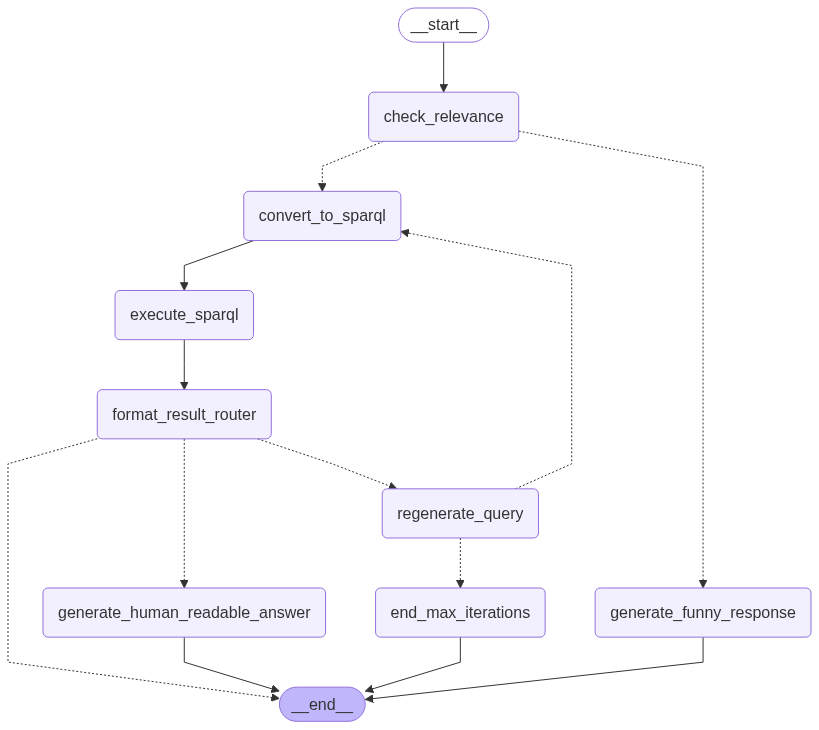

In [14]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    print("Graph visualization not available - install graphviz and pillow if needed")


## Example Queries and Testing
 - Demonstrates usage of the Stardog KG Agent with sample questions
 - Tests product catalog queries and error handling
 - Shows how to handle both relevant and irrelevant queries
 - Requires a running Stardog instance with loaded data


In [15]:
# Example 1: Query orders and product details
user_question_1 = "List all the products families and thier products available"
try:
    result_1 = app.invoke({"question": user_question_1, "attempts": 1})
    print("Result:", result_1["query_result"])
except Exception as e:
    print(f"Error running query: {e}")
    print("Note: This requires a running Stardog instance with the appropriate data loaded.")


Checking relevance of the question: List all the products families and thier products available
Relevance determined: not_relevant
Generating a funny response for an unrelated question.
Generated funny response.
Result: Absolutely! Diving into a knowledge graph is like spelunking through a cave of connections—every corner hides a spark of “Aha!” Here are a few playful pathways we could wander down:

•   From Shakespeare to Modern Memes  
     •  Node A: “Hamlet”  
     •  Node B: Internet “Existential Crisis” memes  
     •  How they connect: Themes of doubt → iconic soliloquy lines → teenage TikTok creators  

•   Beethoven ↔ Napoleonic Europe  
     •  Node A: Beethoven’s Third Symphony (“Eroica”)  
     •  Node B: Napoleon Bonaparte’s rise and fall  
     •  How they connect: Original dedication to Napoleon → political disillusionment → the birth of Romantic-era composers  

•   Cats on YouTube to Quantum Physics  
     •  Node A: Viral cat videos  
     •  Node B: Schrödinger’s cat

In [16]:
# # Example 2: Test irrelevant question
# user_question_2 = "Tell me a joke about knowledge graphs."
# try:
#     result_2 = app.invoke({"question": user_question_2, "attempts": 1})
#     print("Result:", result_2["query_result"])
# except Exception as e:
#     print(f"Error running query: {e}")
#     print("Note: This requires a running Stardog instance and LLM configuration.")
